In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras

# Display
from IPython.display import Image, display
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# Fix randomness and hide warnings
seed = 42

import os

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"
os.environ["PYTHONHASHSEED"] = str(seed)
os.environ["MPLCONFIGDIR"] = os.getcwd() + "/configs/"

import warnings

warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=Warning)

import numpy as np

np.random.seed(seed)

import logging

import random

random.seed(seed)

# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

from sklearn.model_selection import train_test_split


2.14.0


# Loading model


In [ ]:
# Read readme.md from github
from google.colab import drive
drive.mount('/gdrive')
%cd "/gdrive/My Drive/Challenge_1/"

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Challenge_1


In [ ]:
moj_model = tfk.models.load_model('model_model2_1')

# Grad CAM algorithm

In [ ]:
from tensorflow.keras.models import Model
import tensorflow as tf
import numpy as np
import cv2

class GradCAM:
    def __init__(self, model, classIdx, layerName=None):
        # store the model, the class index used to measure the class
        # activation map, and the layer to be used when visualizing
        # the class activation map
        self.model = model
        self.classIdx = classIdx
        self.layerName = layerName
        # if the layer name is None, attempt to automatically find
        # the target output layer
        if self.layerName is None:
            self.layerName = self.find_target_layer()

    def find_target_layer(self):
        # attempt to find the final convolutional layer in the network
        # by looping over the layers of the network in reverse order
        for layer in reversed(self.model.layers):
            # check to see if the layer has a 4D output
            if len(layer.output_shape) == 4:
                return layer.name
        # otherwise, we could not find a 4D layer so the GradCAM
        # algorithm cannot be applied
        raise ValueError("Could not find 4D layer. Cannot apply GradCAM.")


    def compute_heatmap(self, image, eps=1e-8):
        # construct our gradient model by supplying (1) the inputs
        # to our pre-trained model, (2) the output of the (presumably)
        # final 4D layer in the network, and (3) the output of the
        # softmax activations from the model
        gradModel = Model(
            inputs=[self.model.inputs],
            outputs=[self.model.get_layer(self.layerName).output, self.model.output])

        # record operations for automatic differentiation
        with tf.GradientTape() as tape:
            # cast the image tensor to a float-32 data type, pass the
            # image through the gradient model, and grab the loss
            # associated with the specific class index
            inputs = tf.cast(image, tf.float32)
            (convOutputs, predictions) = gradModel(inputs)

            loss = predictions[:, tf.argmax(predictions[0])]

        # use automatic differentiation to compute the gradients
        grads = tape.gradient(loss, convOutputs)

        # compute the guided gradients
        castConvOutputs = tf.cast(convOutputs > 0, "float32")
        castGrads = tf.cast(grads > 0, "float32")
        guidedGrads = castConvOutputs * castGrads * grads
        # the convolution and guided gradients have a batch dimension
        # (which we don't need) so let's grab the volume itself and
        # discard the batch
        convOutputs = convOutputs[0]
        guidedGrads = guidedGrads[0]

        # compute the average of the gradient values, and using them
        # as weights, compute the ponderation of the filters with
        # respect to the weights
        weights = tf.reduce_mean(guidedGrads, axis=(0, 1))
        cam = tf.reduce_sum(tf.multiply(weights, convOutputs), axis=-1)

        # grab the spatial dimensions of the input image and resize
        # the output class activation map to match the input image
        # dimensions
        (w, h) = (image.shape[2], image.shape[1])
        heatmap = cv2.resize(cam.numpy(), (w, h))
        # normalize the heatmap such that all values lie in the range
        # [0, 1], scale the resulting values to the range [0, 255],
        # and then convert to an unsigned 8-bit integer
        numer = heatmap - np.min(heatmap)
        denom = (heatmap.max() - heatmap.min()) + eps
        heatmap = numer / denom
        heatmap = (heatmap * 255).astype("uint8")
        # return the resulting heatmap to the calling function
        return heatmap

    def overlay_heatmap(self, heatmap, image, alpha=0.5,
                        colormap=cv2.COLORMAP_VIRIDIS):
        # apply the supplied color map to the heatmap and then
        # overlay the heatmap on the input image
        heatmap = cv2.applyColorMap(heatmap, colormap)
        output = cv2.addWeighted(image, alpha, heatmap, 1 - alpha, 0)
        # return a 2-tuple of the color mapped heatmap and the output,
        # overlaid image
        return (heatmap, output)

# Importing the dataset

In [ ]:
dataset = np.load('new_dataset.npz', allow_pickle=True) #If you are running it using Colab
images = dataset['data']
labels = dataset['labels']

# Extract classes separately
healthy_labels = np.where(labels == "healthy")[0]
unhealthy_labels = np.where(labels == "unhealthy")[0]

healthy_images = images[healthy_labels]
unhealthy_images = images[unhealthy_labels]

X = np.concatenate([healthy_images, unhealthy_images], axis=0)
y = np.concatenate([np.zeros(len(healthy_images)), np.ones(len(unhealthy_images))], axis=0)

# Split data into train_val and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(
    X, y, random_state=seed, test_size=0.1, stratify=y
)

# Further split train_val into train and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val,
    y_train_val,
    random_state=seed,
    test_size=0.18,
    stratify=y_train_val,
)

# Print shapes of the datasets
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

import os
from PIL import Image
import numpy as np
from tqdm.auto import tqdm

# Create a mapping from integer labels to string names
label_names = np.array(["healthy", "unhealthy"])  # Note: Corrected the array definition

# Create folder to store the images in Colab's local disk
root_dir = '/content/test'  # Use the '/content' directory in Colab
os.makedirs(root_dir, exist_ok=True)

# Get the total number of samples in the dataset
n_samples = len(X_test)

# Iterate through the dataset to save images
for i, (image, label) in enumerate(zip(X_test, y_test)):
    # Convert integer label to string name
    label_name = label_names[int(label)]

    # Create class directory if it doesn't exist
    class_dir = os.path.join(root_dir, label_name)
    os.makedirs(class_dir, exist_ok=True)

    # Define image path and save image
    image_path = os.path.join(class_dir, f'image_{i}.jpg')
    img = np.squeeze(image)  # Remove any singleton dimensions
    img = Image.fromarray(image.astype('uint8'))
    img.save(image_path)


X_train shape: (3343, 96, 96, 3), y_train shape: (3343,)
X_val shape: (735, 96, 96, 3), y_val shape: (735,)
X_test shape: (454, 96, 96, 3), y_test shape: (454,)


In [ ]:

IMG_SIZE = 224

# Classifying an image
* this image is used for generating a heatmap

In [ ]:
img_path = "/content/test/unhealthy/image_14.jpg"

In [ ]:
def proc_input(X_input):
    X_input = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(X_input)
    X_input = tf.cast(X_input, tf.float32)
    X_input = tf.keras.applications.efficientnet.preprocess_input(X_input)
    return X_input

In [ ]:
image = keras.utils.load_img(img_path)
image = keras.utils.img_to_array(img)
image = np.expand_dims(image, axis=0)
image = tfkl.Resizing(IMG_SIZE, IMG_SIZE)(image)
image = proc_input(image)

preds = moj_model.predict(image)
i = (preds > 0.5).astype(int)

image = image / 255


1/1 [==============================] - 0s 27ms/step


In [ ]:
i, preds

(array([[1]]), array([[0.9396052]], dtype=float32))

In [ ]:
image.shape

TensorShape([1, 224, 224, 3])

In [ ]:
for idx in range(len(moj_model.layers)):
  print(moj_model.get_layer(index = idx).name)


input_2
img_augmentation
rescaling
normalization
rescaling_1
stem_conv_pad
stem_conv
stem_bn
stem_activation
block1a_dwconv
block1a_bn
block1a_activation
block1a_se_squeeze
block1a_se_reshape
block1a_se_reduce
block1a_se_expand
block1a_se_excite
block1a_project_conv
block1a_project_bn
block2a_expand_conv
block2a_expand_bn
block2a_expand_activation
block2a_dwconv_pad
block2a_dwconv
block2a_bn
block2a_activation
block2a_se_squeeze
block2a_se_reshape
block2a_se_reduce
block2a_se_expand
block2a_se_excite
block2a_project_conv
block2a_project_bn
block2b_expand_conv
block2b_expand_bn
block2b_expand_activation
block2b_dwconv
block2b_bn
block2b_activation
block2b_se_squeeze
block2b_se_reshape
block2b_se_reduce
block2b_se_expand
block2b_se_excite
block2b_project_conv
block2b_project_bn
block2b_drop
block2b_add
block3a_expand_conv
block3a_expand_bn
block3a_expand_activation
block3a_dwconv_pad
block3a_dwconv
block3a_bn
block3a_activation
block3a_se_squeeze
block3a_se_reshape
block3a_se_reduce
bloc

In [ ]:
icam = GradCAM(moj_model, i, 'block7a_project_conv')
heatmap = icam.compute_heatmap(image)
heatmap = cv2.resize(heatmap, (96, 96))

image = cv2.imread(img_path)
image = cv2.resize(image, (96, 96))
print(heatmap.shape, image.shape)

(heatmap, output) = icam.overlay_heatmap(heatmap, image, alpha=0.5)

(96, 96) (96, 96, 3)


# Generated heatmap

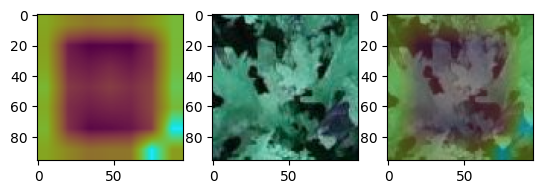

In [ ]:
fig, ax = plt.subplots(1, 3)

ax[0].imshow(heatmap)
ax[1].imshow(image)
ax[2].imshow(output)